# Associations between microbial presence/absence and patient info

In [1]:
setwd("/mnt/c/Users/Cedric/Desktop/git_repos/blood_microbiome")
require(tidyverse)
require(ggplot2)
require(data.table)
require(foreach)
require(doParallel)
require(ggrepel)
require(Maaslin2)
registerDoParallel(cores = 10)


Loading required package: tidyverse

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: data.table


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


Loading required package: foreach


Attaching package: ‘foreach’


The following objects are masked from ‘package:purrr’:

    accumulate, when


Loading required packag

### Load  data

In [2]:
X <- fread("results/decontamination/prevalence_RA0.005_read10.csv")
nc <- fread("results/decontamination/curated_n124_global_decontamination_stats.csv")
X <- X %>% select(all_of(c("npm_research_id", nc$taxa)))

meta <- fread("data/20210125_v3_release/20210203_all_traits_v3.txt")
meta2 <- fread("data/SG10K_Health_metadata.n10714.16March2021.parsed.csv")

n <- gsub("[^0-9A-Za-z///' ]", " ", colnames(meta))
n <- tolower(n)
n <- gsub(" ", "_", n)
colnames(meta) <- n

fwrite(meta, "data/20210125_v3_release/20210203_all_traits_v3.parsed.csv")
X_meta <- X %>%
    left_join(meta, "npm_research_id") %>%
    left_join(meta2, "npm_research_id") %>%
    filter(site_supplying_sample == "GUSTO") %>%
    as_tibble()

X_meta

npm_research_id,Fusobacterium nucleatum,Staphylococcus haemolyticus,Cutibacterium acnes,Staphylococcus cohnii,Human mastadenovirus C,Neisseria subflava,Corynebacterium segmentosum,Haemophilus parainfluenzae,Fannyhessea vaginae,⋯,supplied_and_computed_gender_match,sop_agreement_for_coverage__14/_28_for_15x/30x,sample_life_cycle,current,source_cohort,original_supplier_id,duplicate_info.y,duplicate.y,duplicate_pair.y,removal_requested_by_supplier
<chr>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
WHB4505,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,Y,Y,GUSTO_Kids VCF,Y,GUSTO_Kids,010-21829,Unknown,PASS,Unknown,Unknown
WHB4533,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,Y,Y,GUSTO_Kids VCF,Y,GUSTO_Kids,010-20179,Unknown,PASS,Unknown,Unknown
WHB3986,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,Y,Y,GUSTO_Kids VCF,Y,GUSTO_Kids,010-21163,Unknown,PASS,Unknown,Unknown
WHB4136,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,Y,Y,GUSTO_Kids VCF,Y,GUSTO_Kids,010-20349,Unknown,PASS,Unknown,Unknown
WHB4399,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,Y,Y,GUSTO_Kids VCF,Y,GUSTO_Kids,010-21153,Unknown,PASS,Unknown,Unknown
WHB3998,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,Y,Y,GUSTO_Kids VCF,Y,GUSTO_Kids,019-30294,Unknown,PASS,Unknown,Unknown
WHB4494,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,Y,Y,GUSTO_Kids VCF,Y,GUSTO_Kids,010-21703,Unknown,PASS,Unknown,Unknown
WHB3946,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,Y,Y,GUSTO_Kids VCF,Y,GUSTO_Kids,020-66149,Unknown,PASS,Unknown,Unknown
WHB3884,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,Y,Y,GUSTO_Kids VCF,Y,GUSTO_Kids,019-30333,Unknown,PASS,Unknown,Unknown


#### Variable list

In [3]:
categorical_list <- c("fasting", "genetic_sex", "genetic_ancestry", 
                      "diab_med", "htn_med", "lipid_med", "t2d")
cont_list <- c("age", "bmi", 
               "height_cm", "weight_kg", "waistc_cm", "hipc_cm", 
               "tc_mmol_l", "ldl_direct_mmol_l", "hdl_mmol_l", "tg_mmol_l",
               "glu_fast_mmol_l", "ins_fast_uiu_ml", "glu_rand_mmol_l",
               "ldl_cal_mmol_l",              
               "sbp", "dbp")

bad_var <- foreach (var_name = c(categorical_list, cont_list), .combine = "c") %do% {
    n_levels <- X_meta %>% 
        filter(!is.na(get(var_name))) %>%
        summarise(n = n_distinct(get(var_name)))
    
    if (n_levels < 2) {
        var_name
    }
    
}

var_list <- c(categorical_list, cont_list)
var_list <- var_list[!(var_list %in% bad_var)]

length(var_list)

[1] 15

#### Taxon list

In [4]:
# Get variable lists
taxon_list <- colSums(X[, 2:ncol(X)]) >= 10
taxon_list <- names(taxon_list[taxon_list])
length(taxon_list)

[1] 63

## Phenotype association tests

### GLM function

In [5]:
glm_test <- function(var_name, taxon) {
    print(str_glue("Running test for {taxon} ~ {var_name}"))
    
    X_meta_filt <- X_meta %>% 
        filter(!is.na(get(var_name)))
    
    if (var_name %in% categorical_list) {
        var_vec <- factor(deframe(X_meta_filt[, var_name]))
    } else {
        var_vec <- deframe(X_meta_filt[, var_name])
    }
    
    species_vec <- deframe(X_meta_filt[, taxon])
    cohort_vec <- X_meta_filt$site_supplying_sample

    # Fit glm
    logreg <- glm(species_vec ~ var_vec, family = "binomial")

    # Extract log-odds
    logres <- coef(summary(logreg))

    # Extract reference level for multilevel factors
    ref_level <- logreg$xlevels$var_vec[1]

    if (is.null(ref_level)) {
        ref_level <- NA
    }
    
    # Analysis of deviance
    aod <- anova(logreg, test = "Chisq")

    # If continuous variable, let 
    if (length(logreg$xlevels$var_vec) >= 2) {
        var_levels <- logreg$xlevels$var_vec
    } else {
        var_levels <- c("var_vec")
    }
    
    # Compute Wald confidence intervals (b +- z* SE(b))
    confint_res <- confint.default(logreg)
    
    # Collate results
    crumbs <- foreach (l = var_levels) %do% {
        effect_name <- ifelse(length(logreg$xlevels$var_vec) >= 2, paste0("var_vec", l), "var_vec")

        if (is.na(ref_level)| !is.na(ref_level) & l != ref_level) {
            # Extract confidence intervals
            lower_bound <- exp(confint_res[effect_name, "2.5 %"])
            upper_bound <- exp(confint_res[effect_name, "97.5 %"])
            
            # All results
            tibble(taxa = taxon,
                   variable = var_name,
                   ref_level = ref_level,
                   effect_of = l,
                   param_estimate = logres[effect_name, "Estimate"],
                   OR_CI_2.5 = lower_bound,
                   OR_CI_97.5 = upper_bound,
                   param_z = logres[effect_name, "z value"],
                   param_p.val = logres[effect_name, "Pr(>|z|)"],
                   d_deviance = aod["var_vec", "Deviance"],
                   AOD_p.val = aod["var_vec", "Pr(>Chi)"])
        }
    }

    bind_rows(crumbs)
}

### Run GLM for all taxa and variables

In [6]:
morsels <- foreach(var_name = var_list) %dopar% {
    foreach(taxon = taxon_list) %do% {
        glm_test(var_name, taxon)
    }
}


### Parse results

#### Number of analysis of deviance tests

In [7]:
n_comparisons_aod <- length(taxon_list) * length(var_list)
n_comparisons_aod

[1] 945

In [8]:
final_AOD <- bind_rows(morsels) %>%
    distinct(taxa, variable, .keep_all = T) %>%
    mutate(AOD_p.adj = p.adjust(AOD_p.val, method = "BH", n = n_comparisons_aod)) %>%
    select(taxa, variable, AOD_p.adj)

final <- bind_rows(morsels) %>%
    left_join(final_AOD, by = c("taxa", "variable")) %>%
    mutate(param_p.adj = p.adjust(param_p.val, method = "BH"), .after = 9) %>%
    mutate(odds_ratio = exp(param_estimate), .after = 5) %>%
    mutate(effect_size = ifelse(odds_ratio > 1, 
                                odds_ratio, 
                                1 / odds_ratio), 
           log_effect_size = ifelse(odds_ratio > 1, 
                                log(odds_ratio, base = 10), 
                                log(1 / odds_ratio, base = 10)), .after = 6)

to_save <- final %>% 
    filter(AOD_p.adj < 0.05) %>%
    arrange(desc(effect_size)) 

to_save

final_AOD %>% filter(AOD_p.adj < 0.05)

# fwrite(to_save, "results/phenotype_associations/phenotype_association_results.csv")


taxa,variable,ref_level,effect_of,param_estimate,odds_ratio,effect_size,log_effect_size,OR_CI_2.5,OR_CI_97.5,param_z,param_p.val,param_p.adj,d_deviance,AOD_p.val,AOD_p.adj
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Bifidobacterium adolescentis,genetic_ancestry,C,I,2.068822,7.915492,7.915492,0.8984779,3.483091,17.98833,4.939467,7.833645e-07,0.0007896315,29.65941,3.626944e-07,0.0003427462
Bifidobacterium adolescentis,genetic_ancestry,C,M,1.513238,4.541413,4.541413,0.6571910,1.977820,10.42786,3.568021,3.596874e-04,0.1208549780,29.65941,3.626944e-07,0.0003427462


taxa,variable,AOD_p.adj
<chr>,<chr>,<dbl>
Bifidobacterium adolescentis,genetic_ancestry,0.0003427462


In [9]:
taxon_list

[1] "Fusobacterium nucleatum"             
 [2] "Staphylococcus haemolyticus"         
 [3] "Cutibacterium acnes"                 
 [4] "Staphylococcus cohnii"               
 [5] "Human mastadenovirus C"              
 [6] "Neisseria subflava"                  
 [7] "Haemophilus parainfluenzae"          
 [8] "Fannyhessea vaginae"                 
 [9] "Staphylococcus epidermidis"          
[10] "Human betaherpesvirus 6A"            
[11] "Human betaherpesvirus 6B"            
[12] "Lactobacillus crispatus"             
[13] "Acinetobacter baumannii"             
[14] "Cupriavidus metallidurans"           
[15] "Neisseria mucosa"                    
[16] "Malassezia restricta"                
[17] "Prevotella melaninogenica"           
[18] "Moraxella osloensis"                 
[19] "Gardnerella vaginalis"               
[20] "Mycolicibacterium aubagnense"        
[21] "Faecalibacterium prausnitzii"        
[22] "Rothia mucilaginosa"                 
[23] "Phocaeicola vulgatus"                
[24] "Prevotella intermedia"               
[25] "Lactobacillus iners"                 
[26] "Bifidobacterium longum"              
[27] "Phocaeicola dorei"                   
[28] "Rubrobacter xylanophilus"            
[29] "Streptococcus mitis"                 
[30] "Corynebacterium kefirresidentii"     
[31] "Bifidobacterium bifidum"             
[32] "Neisseria sicca"                     
[33] "Streptococcus oralis"                
[34] "Bifidobacterium breve"               
[35] "Lautropia mirabilis"                 
[36] "Comamonas aquatica"                  
[37] "Streptococcus sp. oral taxon 061"    
[38] "Propionibacterium sp. oral taxon 193"
[39] "Rothia aeria"                        
[40] "Corynebacterium tuberculostearicum"  
[41] "Ruminococcus gnavus"                 
[42] "Phyllobacterium zundukense"          
[43] "Acidovorax sp. KKS102"               
[44] "Ruminococcus torques"                
[45] "Staphylococcus capitis"              
[46] "Corynebacterium jeikeium"            
[47] "Epilithonimonas vandammei"           
[48] "Collinsella aerofaciens"             
[49] "Acinetobacter dispersus"             
[50] "Lactobacillus jensenii"              
[51] "Anaerostipes hadrus"                 
[52] "Bifidobacterium adolescentis"        
[53] "Streptococcus sanguinis"             
[54] "Acinetobacter schindleri"            
[55] "Paraburkholderia acidiphila"         
[56] "Coprococcus comes"                   
[57] "Paraburkholderia sp. 7MH5"           
[58] "Streptococcus pneumoniae"            
[59] "Paraburkholderia aromaticivorans"    
[60] "Paraburkholderia tropica"            
[61] "Staphylococcus aureus"               
[62] "Paraburkholderia acidisoli"          
[63] "Blautia sp. SC05B48"

Warning message:
“Removed 944 rows containing missing values (geom_point).”


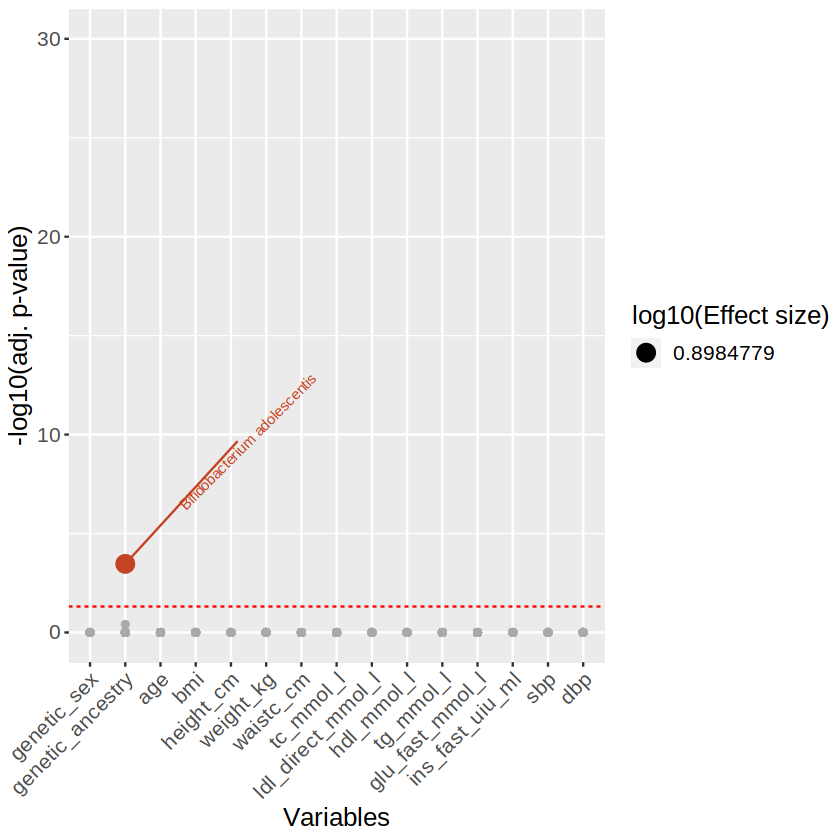

In [10]:
a <- 0.05

plot_df <- final %>%
    group_by(taxa, variable) %>%
    mutate(max_OR = max(odds_ratio)) %>%
    ungroup() %>%
    distinct(taxa, variable, .keep_all = T) %>%
    mutate(log_p_adj = -log(AOD_p.adj, base = 10),
           p.val_annot = ifelse(AOD_p.adj < a & param_p.adj < a, taxa, ""),
           OR_annot = ifelse(AOD_p.adj < a & param_p.adj < a, log_effect_size, NA),
           variable = factor(variable, levels = c(categorical_list, cont_list)),
           color_value = ifelse(AOD_p.adj < a & param_p.adj < a, log_p_adj, NA))

plot_df %>%
    ggplot(aes(x = variable, y = log_p_adj, color = color_value)) +
    geom_point() +
    geom_point(aes(size = OR_annot)) +
    geom_hline(yintercept = -log(a, base = 10), 
               lty = "dashed",
               color = "red") +
    scale_color_gradient(low = "orangered4", 
                         high = "tomato1", 
                         na.value = "darkgray", 
                         guide = "none") + 
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
          text = element_text(size = 15)) +
    geom_text_repel(aes(label = p.val_annot), angle = 45, hjust = 0, size = 3) +
    labs(x = "Variables", y = "-log10(adj. p-value)",
         size = "log10(Effect size)") +
    ylim(0, 30)

# ggsave("results/phenotype_associations/manhattan_plot.glm.png", dpi = 600, width = 12)

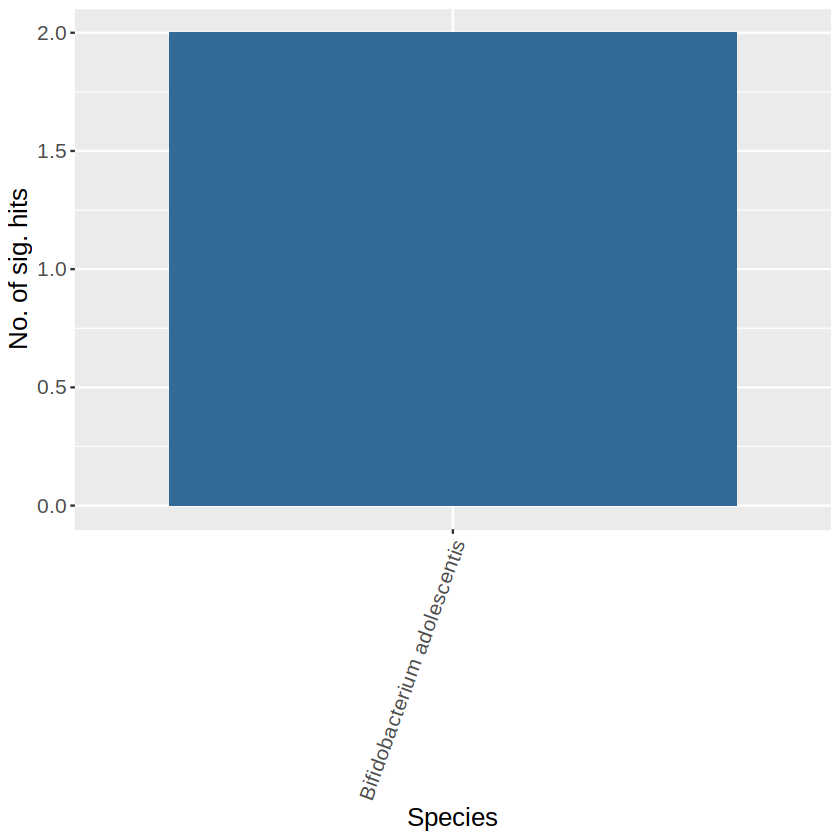

In [11]:
taxa_counts <- final %>%
    mutate(is_sig = ifelse(AOD_p.adj < a, T, F)) %>%
    filter(is_sig) %>%
    group_by(taxa) %>%
    summarise(n = n()) %>%
    arrange(desc(n))

hit_plt <- taxa_counts %>%
    mutate(taxa = factor(taxa, unique(taxa_counts$taxa))) %>%
    ggplot(aes(x = taxa, y = n, fill = n)) +
    geom_bar(stat = "identity") +
    theme(legend.position = "none", 
          axis.text.x = element_text(angle = 70, hjust = 1),
          text = element_text(size = 15)) +
    labs(x = "Species", y = "No. of sig. hits")

hit_plt
# ggsave("results/phenotype_associations/assoc_hit_count_barchart.png", dpi = 600)

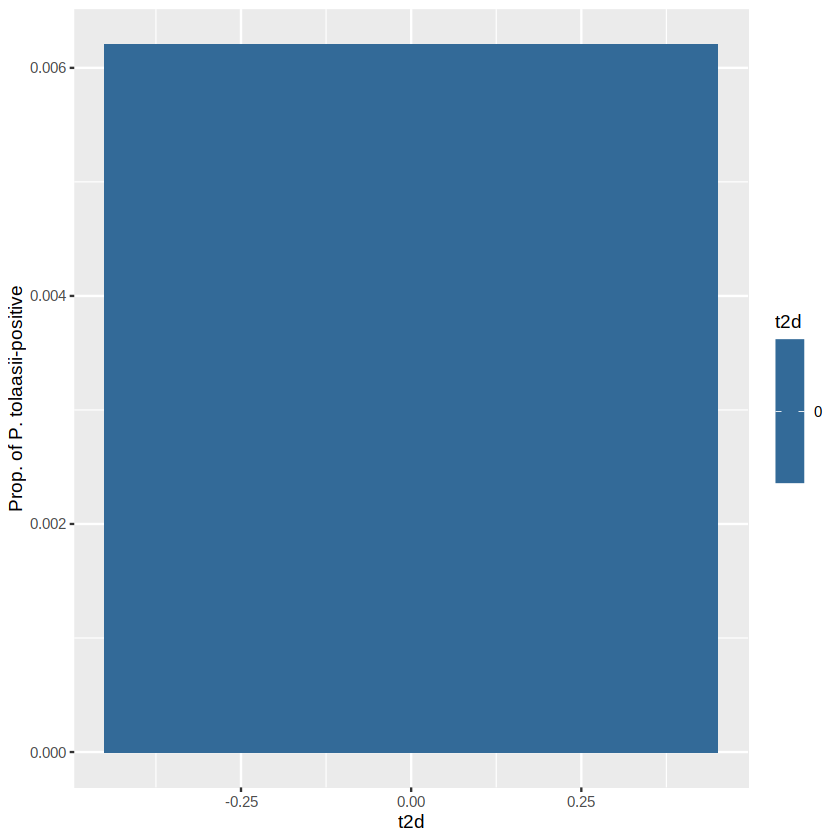

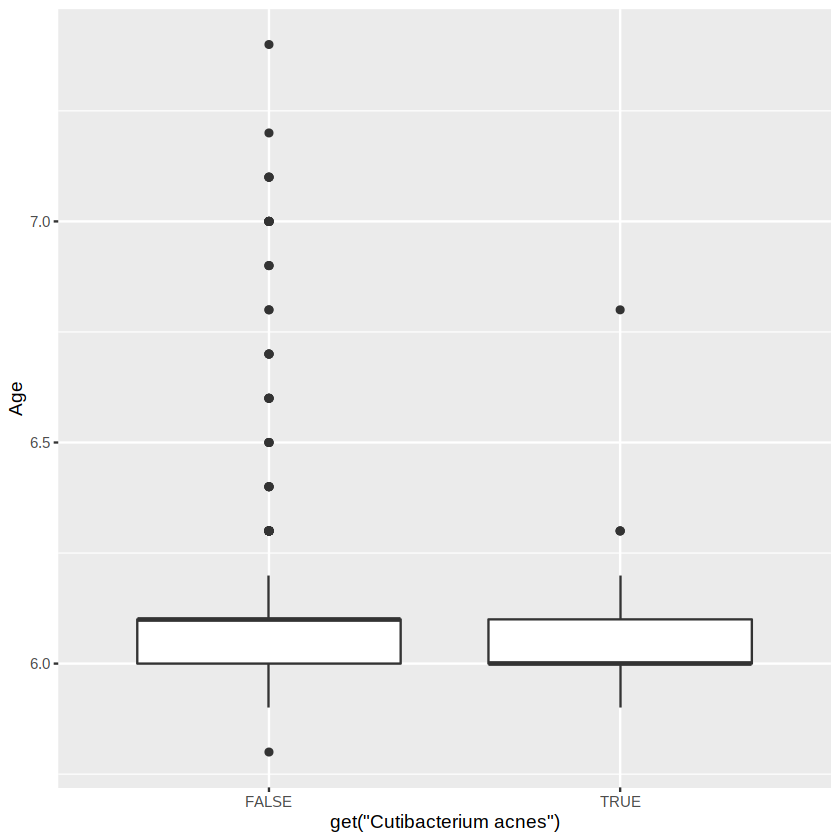

In [12]:
X_meta %>%
    left_join(meta2, "npm_research_id") %>%
    filter(!is.na(t2d)) %>%
    group_by(t2d) %>%
    summarise(prop = sum(get("Human mastadenovirus C")) / n()) %>%
    ggplot(aes(x = t2d, y = prop, fill = t2d))  +
        geom_bar(stat = "identity") +
        labs(y = "Prop. of P. tolaasii-positive")

X_meta %>%
    left_join(meta2, "npm_research_id") %>%
    filter(!is.na(age)) %>%
    ggplot(aes(x = get("Cutibacterium acnes"), y = age))  +
        geom_boxplot() +
        labs(y = "Age")

In [13]:
X_meta %>%
    left_join(meta2, "npm_research_id") %>%
    filter(!is.na(genetic_ancestry)) %>%
    group_by(genetic_ancestry) %>%
    summarise(prop = sum(get("Pseudomonas tolaasii")) / n()) %>%
    ggplot(aes(x = genetic_ancestry, y = prop, fill = genetic_ancestry))  +
        geom_bar(stat = "identity") +
        labs(y = "Prop. of P. tolaasii-positive")

X_meta %>%
    left_join(meta2, "npm_research_id") %>%
    filter(!is.na(genetic_ancestry)) %>%
    group_by(genetic_ancestry) %>%
    summarise(prop = sum(get("Microbacterium sp. PM5")) / n()) %>%
    ggplot(aes(x = genetic_ancestry, y = prop, fill = genetic_ancestry))  +
        geom_bar(stat = "identity") +
        labs(y = "Prop. of Microbacterium-positive")

X_meta %>%
    left_join(meta2, "npm_research_id") %>%
    filter(!is.na(genetic_ancestry)) %>%
    group_by(genetic_ancestry) %>%
    summarise(prop = sum(get("Paraburkholderia sp. 7MH5")) / n()) %>%
    ggplot(aes(x = genetic_ancestry, y = prop, fill = genetic_ancestry))  +
        geom_bar(stat = "identity") +
        labs(y = "Prop. of Microbacterium-positive")


ERROR: [1m[33mError[39m in [1m[1m[30m[47m`h()`[49m[39m:[22m
[33m![39m Problem with `summarise()` column `prop`.
[34mℹ[39m `prop = sum(get("Pseudomonas tolaasii"))/n()`.
[31m✖[39m object 'Pseudomonas tolaasii' not found
[34mℹ[39m The error occurred in group 1: genetic_ancestry = "C".
